# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
import torch.nn as nn
import torchvision 
from torchvision import transforms , datasets
from torch.utils.data import DataLoader 
from torchvision import models as pretrained_models
from torchvision.transforms.autoaugment import InterpolationMode
from torch.optim import lr_scheduler


In [3]:
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix , accuracy_score , classification_report


In [4]:
from pathlib import Path
import os
from PIL import Image

In [5]:
from tqdm import tqdm

In [6]:
import time

# Setting Directories

In [7]:
root = Path('data')
train_dir = root / 'train'
test_dir = root / 'test'

In [8]:
#checking directories

In [9]:
#list all paths inside train and test directories
train_all_path = list(train_dir.glob('*.jpg'))
len(train_all_path)

6499

In [10]:
test_all_path = list(test_dir.glob('*.jpg'))
len(test_all_path)

2786

In [11]:
train_csv = 'Training_set.csv'
test_csv = 'Testing_set.csv'

# Data Preparation

In [12]:
train_df = pd.read_csv(train_csv)
train_df

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART
...,...,...
6494,Image_6495.jpg,MANGROVE SKIPPER
6495,Image_6496.jpg,MOURNING CLOAK
6496,Image_6497.jpg,APPOLLO
6497,Image_6498.jpg,ELBOWED PIERROT


In [13]:
test_df = pd.read_csv(test_csv)
test_df

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg
...,...
2781,Image_2782.jpg
2782,Image_2783.jpg
2783,Image_2784.jpg
2784,Image_2785.jpg


In [14]:
len(train_all_path) == len(train_df) #check if csv contain all images inside train_directory?![as numbers, you can go deeper by checking if file names exist on the dataframe csv]

True

In [15]:
len(test_all_path) == len(test_df)

True

# simple EDA 

### check if dataframes has any dulicate records

In [16]:
train_df['Duplicate'] = train_df.duplicated()

In [17]:
train_df[train_df['Duplicate']] #if empy then no duplicates are there 

,filename,label,Duplicate


In [18]:
train_df[(train_df.index != train_df.index) & (train_df.filename == train_df.filename) ] #check if we are having same filename with different label

,filename,label,Duplicate


In [19]:
# Now after we haved check data we are having the green light to drop the duplicate column

In [20]:
train_df.drop('Duplicate',  axis = 1,inplace = True)

In [21]:
train_df.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [22]:
#lets add full path to the dataframe
train_df['path'] = str(train_dir)+'\\' + train_df['filename']

In [23]:
train_df

,filename,label,path
0,Image_1.jpg,SOUTHERN DOGFACE,data\train\Image_1.jpg
1,Image_2.jpg,ADONIS,data\train\Image_2.jpg
2,Image_3.jpg,BROWN SIPROETA,data\train\Image_3.jpg
3,Image_4.jpg,MONARCH,data\train\Image_4.jpg
4,Image_5.jpg,GREEN CELLED CATTLEHEART,data\train\Image_5.jpg
...,...,...,...
6494,Image_6495.jpg,MANGROVE SKIPPER,data\train\Image_6495.jpg
6495,Image_6496.jpg,MOURNING CLOAK,data\train\Image_6496.jpg
6496,Image_6497.jpg,APPOLLO,data\train\Image_6497.jpg
6497,Image_6498.jpg,ELBOWED PIERROT,data\train\Image_6498.jpg


In [24]:
#lets do the same for test_df
test_df['path'] = str(test_dir) + '\\' + test_df['filename']

In [25]:
test_df

,filename,path
0,Image_1.jpg,data\test\Image_1.jpg
1,Image_2.jpg,data\test\Image_2.jpg
2,Image_3.jpg,data\test\Image_3.jpg
3,Image_4.jpg,data\test\Image_4.jpg
4,Image_5.jpg,data\test\Image_5.jpg
...,...,...
2781,Image_2782.jpg,data\test\Image_2782.jpg
2782,Image_2783.jpg,data\test\Image_2783.jpg
2783,Image_2784.jpg,data\test\Image_2784.jpg
2784,Image_2785.jpg,data\test\Image_2785.jpg


### check unique labels , how many , plot them



In [26]:
train_df.label.value_counts()

label
MOURNING CLOAK    131
SLEEPY ORANGE     107
ATALA             100
BROWN SIPROETA     99
CRECENT            97
                 ... 
AMERICAN SNOOT     74
GOLD BANDED        73
MALACHITE          73
CRIMSON PATCH      72
WOOD SATYR         71
Name: count, Length: 75, dtype: int64

In [27]:
len(train_df.label.value_counts())

75

<Axes: xlabel='count', ylabel='label'>

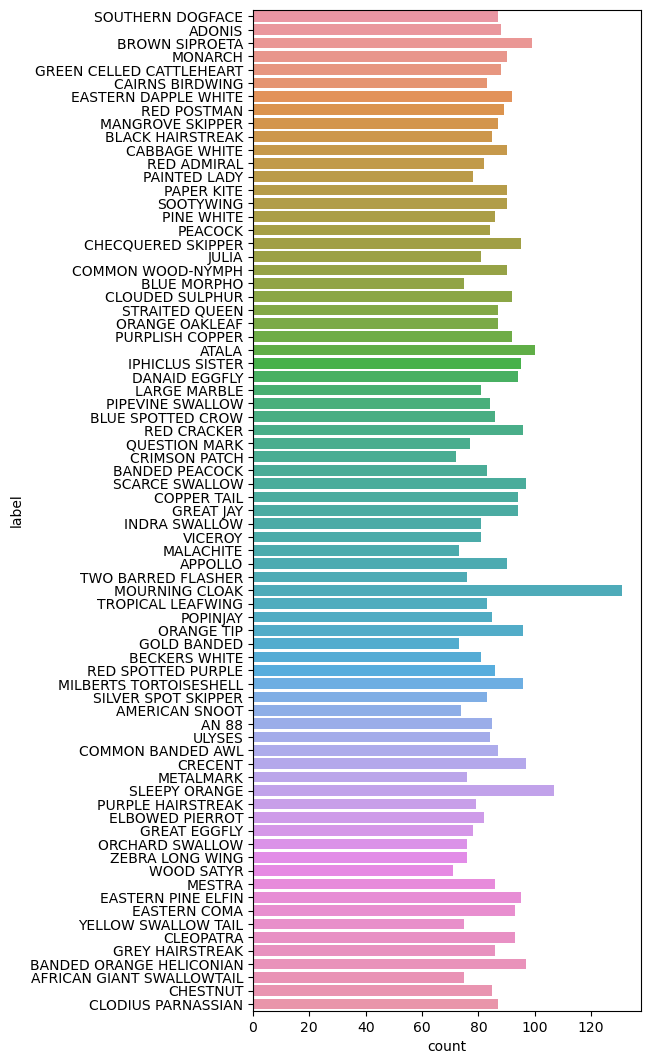

In [28]:
plt.figure(figsize=(5,13))
sns.countplot(y = train_df.label)

In [29]:
# so we have 75 kind of butterfulies , each category or kind is having nearly 80 images , 
# I think this is not enough samples to make neural network learn from them so if we reached 80 percent accuarcy it will be amazing

### check image sizes and if they vary



In [30]:
random_path_list = train_df.sample(16)

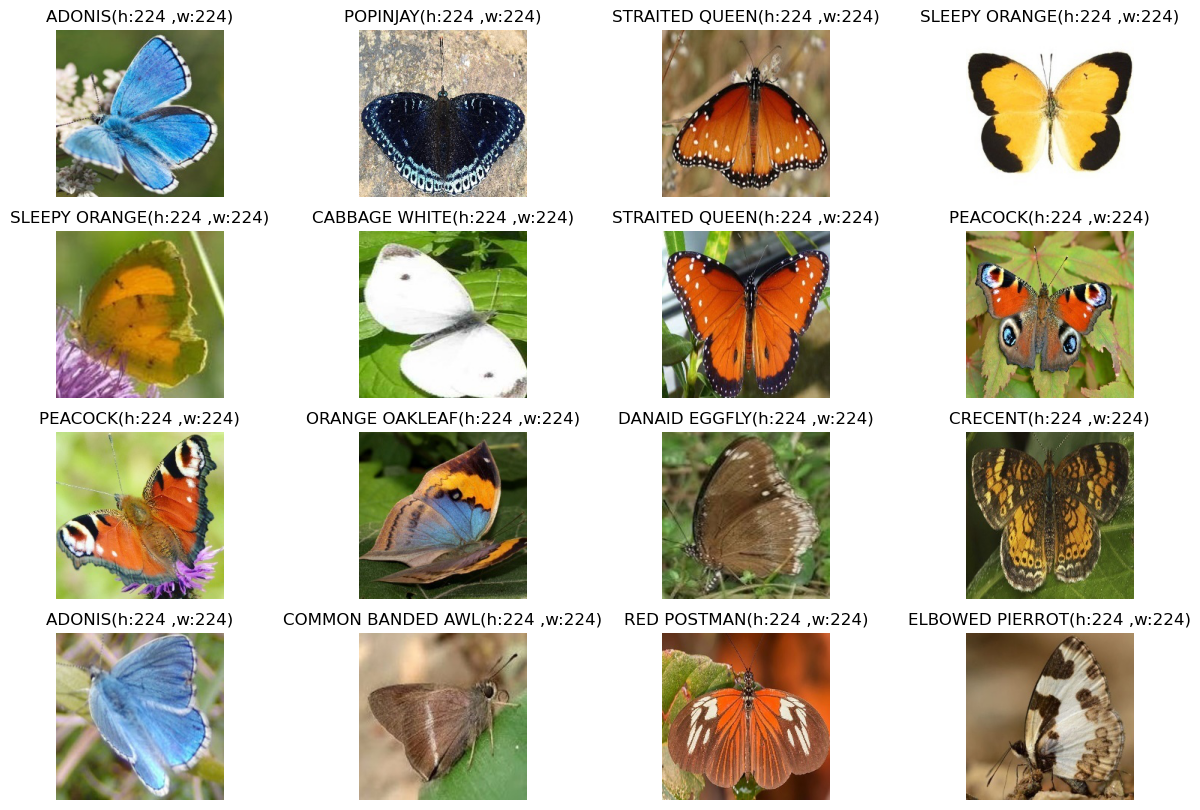

In [31]:
fig , axes = plt.subplots(4 , 4 , figsize = (15 , 10))
axes = axes.flatten()
for i , ax in enumerate(axes):
    ax.imshow(plt.imread(random_path_list.iloc[i]['path']))
    img =  Image.open(random_path_list.iloc[i]['path'])
    ax.set_title(f"{random_path_list.iloc[i].label}(h:{img.height} ,w:{img.width})")
    ax.set_axis_off()
   

In [32]:
#From the random images plotted , you can say that images having 224 * 224 , but anyways I will include it in the transforms

##### Note that I was about to plot some imags of different species or kinds and using mere eye I would expect which kinds will cause consion to the Model later , but  because they are nearly 75 kinds I will make this step later after training the Model

In [33]:
class_names = list(train_df.label.unique())

In [34]:
class_names

['SOUTHERN DOGFACE',
 'ADONIS',
 'BROWN SIPROETA',
 'MONARCH',
 'GREEN CELLED CATTLEHEART',
 'CAIRNS BIRDWING',
 'EASTERN DAPPLE WHITE',
 'RED POSTMAN',
 'MANGROVE SKIPPER',
 'BLACK HAIRSTREAK',
 'CABBAGE WHITE',
 'RED ADMIRAL',
 'PAINTED LADY',
 'PAPER KITE',
 'SOOTYWING',
 'PINE WHITE',
 'PEACOCK',
 'CHECQUERED SKIPPER',
 'JULIA',
 'COMMON WOOD-NYMPH',
 'BLUE MORPHO',
 'CLOUDED SULPHUR',
 'STRAITED QUEEN',
 'ORANGE OAKLEAF',
 'PURPLISH COPPER',
 'ATALA',
 'IPHICLUS SISTER',
 'DANAID EGGFLY',
 'LARGE MARBLE',
 'PIPEVINE SWALLOW',
 'BLUE SPOTTED CROW',
 'RED CRACKER',
 'QUESTION MARK',
 'CRIMSON PATCH',
 'BANDED PEACOCK',
 'SCARCE SWALLOW',
 'COPPER TAIL',
 'GREAT JAY',
 'INDRA SWALLOW',
 'VICEROY',
 'MALACHITE',
 'APPOLLO',
 'TWO BARRED FLASHER',
 'MOURNING CLOAK',
 'TROPICAL LEAFWING',
 'POPINJAY',
 'ORANGE TIP',
 'GOLD BANDED',
 'BECKERS WHITE',
 'RED SPOTTED PURPLE',
 'MILBERTS TORTOISESHELL',
 'SILVER SPOT SKIPPER',
 'AMERICAN SNOOT',
 'AN 88',
 'ULYSES',
 'COMMON BANDED AWL',
 'C

# integet encoding of labels


In [35]:
#as we know strings are not going to be suitable for Ml so I will go for the integer encoding
label_dict = {item:idx for idx , item in enumerate(class_names) }

In [36]:
train_df['class_id'] = train_df['label'].apply(lambda x: label_dict[x])

In [37]:
train_df

,filename,label,path,class_id
0,Image_1.jpg,SOUTHERN DOGFACE,data\train\Image_1.jpg,0
1,Image_2.jpg,ADONIS,data\train\Image_2.jpg,1
2,Image_3.jpg,BROWN SIPROETA,data\train\Image_3.jpg,2
3,Image_4.jpg,MONARCH,data\train\Image_4.jpg,3
4,Image_5.jpg,GREEN CELLED CATTLEHEART,data\train\Image_5.jpg,4
...,...,...,...,...
6494,Image_6495.jpg,MANGROVE SKIPPER,data\train\Image_6495.jpg,8
6495,Image_6496.jpg,MOURNING CLOAK,data\train\Image_6496.jpg,43
6496,Image_6497.jpg,APPOLLO,data\train\Image_6497.jpg,41
6497,Image_6498.jpg,ELBOWED PIERROT,data\train\Image_6498.jpg,60


### [Note: we cannot use the test_df as validation set as its not labeled]

In [38]:
train_df = shuffle(train_df)
len(train_df) // 5 #20% of the data for test , rest for train

1299

In [39]:
train_df = train_df[:4 * len(train_df) // 5]
val_df = train_df[:len(train_df) // 5]

In [40]:
len(train_df)  , len(val_df)

(5199, 1039)

# Transforms


In [41]:
train_transforms = transforms.Compose([
    transforms.Resize((224 , 224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation((-45,45) , InterpolationMode.NEAREST),
    transforms.ToTensor()
])

In [42]:
test_transforms = transforms.Compose([
    transforms.Resize((224 , 224)),
    transforms.ToTensor()
])

# Dataset

In [43]:
class CustomDataset(torch.utils.data.Dataset):
    
    def __init__(self , df , transforms):
        self.df = df
        self.transforms = transforms
        
        
    def __len__(self):
        return len(self.df)
    
    
    
    def __getitem__(self,index):
        img_transformed = self.transforms(Image.open(self.df.iloc[index]['path']).convert("RGB"))
        class_id = self.df.iloc[index]['class_id']
        return img_transformed , class_id

In [44]:
train_ds = CustomDataset(train_df,train_transforms)
test_ds = CustomDataset(val_df , test_transforms)

In [45]:
train_df

,filename,label,path,class_id
6162,Image_6163.jpg,PAPER KITE,data\train\Image_6163.jpg,13
6044,Image_6045.jpg,QUESTION MARK,data\train\Image_6045.jpg,32
204,Image_205.jpg,PURPLISH COPPER,data\train\Image_205.jpg,24
29,Image_30.jpg,ATALA,data\train\Image_30.jpg,25
4614,Image_4615.jpg,CLODIUS PARNASSIAN,data\train\Image_4615.jpg,74
...,...,...,...,...
3958,Image_3959.jpg,TWO BARRED FLASHER,data\train\Image_3959.jpg,42
2078,Image_2079.jpg,GREY HAIRSTREAK,data\train\Image_2079.jpg,70
6295,Image_6296.jpg,AN 88,data\train\Image_6296.jpg,53
3347,Image_3348.jpg,ORANGE TIP,data\train\Image_3348.jpg,46


# DataLoaders



In [46]:
BATCH_SIZE = 42 # this will cause some problem if you used with smaller Graphics card - you have to try the suitable one for ur device

In [47]:
train_dataloader = DataLoader(train_ds , batch_size=BATCH_SIZE , shuffle = True )
val_dataloader = DataLoader(test_ds ,batch_size=BATCH_SIZE)

# Traing and Validation Function

In [48]:
def train_one_epoch(dataloader , model , loss_fn , optimizer , lr_scheduler):
    train_loss , train_acc = 0 , 0
    model.train()
    for batch , (x , y) in enumerate(dataloader):
        #dpla zero bu
        x , y = x.to(device) , y.to(device)
        preds = model(x)
        
        loss = loss_fn(preds,y)
        
        train_loss += loss.item()
        pred_classes = torch.argmax(torch.softmax(preds,dim=1),dim = 1)
        train_acc += torch.sum(pred_classes == y) / len(y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    lr_scheduler.step()
    return train_acc / len(dataloader), train_loss / len(dataloader)

In [49]:
def validate(dataloader , model , loss_fn):
    val_loss , val_acc = 0 , 0
    model.eval()
    with torch.inference_mode():
        for batch , (x, y) in enumerate(dataloader):
            x , y = x.to(device) , y.to(device)
            
            preds = model(x)
            loss =  loss_fn(preds , y)
            val_loss += loss.item()
            pred_classes = torch.argmax(torch.softmax(preds , dim = 1),dim=1)
            val_acc+= torch.sum(y == pred_classes) / len(y)
    return val_acc / len(dataloader) , val_loss / len(dataloader)
            
            

# Building Models

In [64]:
device = torch.device("cpu")

In [65]:
class ConvNet(nn.Module):
    
    def __init__(self , input_channels , hidden_units , output_classes):
        super().__init__()
        #block1 = conv + relu + conv + relu + maxpool
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_channels, out_channels = hidden_units , stride= 1, padding = 1 , kernel_size = 3  ),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, stride= 1, padding = 1 , kernel_size = 3  ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2 , stride = 2)
            
            
        )
        #blcok2 = same as block 1
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units , out_channels = hidden_units , stride= 1, padding = 1 , kernel_size = 3  ),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units  , stride= 1, padding = 1 , kernel_size = 3  ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2 , stride = 2)
        )
        #classifier = flatten , connected nn , output 
        self.classifier = nn.Sequential(
        nn.Flatten() , 
        nn.Linear(in_features= hidden_units  * 56 * 56, out_features = output_classes)
        )
    def forward(self , x):
        #print('1' , x.size())
        x = self.block_1(x)
        #print('2',x.size())
        x = self.block_2(x)
        #print('3' , x.size())
        x = self.classifier(x)
        #print('4' , x.size())
        return x
    

In [66]:
custom_model_1 = ConvNet(input_channels = 3 , hidden_units = 16 , output_classes = len(class_names) )

In [67]:
custom_model_1.to(device)

ConvNet(
  (block_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=50176, out_features=75, bias=True)
  )
)

In [69]:
custom_model_1(torch.randn(1,3,224,224).to(device))

tensor([[-0.0099,  0.0361, -0.0341,  0.0267,  0.0245,  0.0285,  0.0083,  0.0119,
         -0.0234,  0.0084,  0.0329, -0.0396, -0.0083, -0.0182, -0.0377, -0.0073,
         -0.0056,  0.0257, -0.0312, -0.0345,  0.0067,  0.0575,  0.0461,  0.0676,
          0.0036, -0.0013, -0.0330,  0.0523, -0.0195, -0.0082,  0.0699,  0.0173,
          0.0649, -0.0078,  0.0393, -0.0494, -0.0079, -0.0128,  0.0130, -0.0079,
          0.0025, -0.0259, -0.0173,  0.0069, -0.0056, -0.0062, -0.0022, -0.0018,
         -0.0050, -0.0061, -0.0029,  0.0276,  0.0123,  0.0228,  0.0201, -0.0155,
         -0.0043, -0.0427,  0.0219,  0.0113,  0.0118,  0.0211,  0.0080,  0.0105,
         -0.0073,  0.0139,  0.0244, -0.0290, -0.0056, -0.0019,  0.0097, -0.0447,
          0.0088,  0.0579,  0.0565]], grad_fn=<AddmmBackward0>)

#### Training Parameters

In [70]:
BATCH_SIZE = 42

epochs = 300

device = torch.device("cpu")
logs = {'train_acc':[] , 'train_loss':[],
       'val_acc':[] , 'val_loss':[]}

lr_rate = 0.001
lr_milstones = [7 , 14 , 21 , 28 , 35]
optimizer = torch.optim.Adam(custom_model_1.parameters() , lr=lr_rate )

multi_step_lr_scheduler = lr_scheduler.MultiStepLR(optimizer ,
                                                   milestones=lr_milstones,
                                                  gamma = 0.1)



criterion = nn.CrossEntropyLoss()
patience = 10 
counter = 0
best_loss = 100_000_000 #very big numper you can use np.inf but I prefer this

In [71]:
for epoch in tqdm(range(epochs)):
    train_acc , train_loss = train_one_epoch(train_dataloader ,
                                            custom_model_1,
                                            criterion,
                                            optimizer,
                                            multi_step_lr_scheduler)
    val_acc , val_loss = validate(val_dataloader , custom_model_1 , criterion)
    
    logs['train_acc'].append(train_acc)
    logs['train_loss'].append(train_loss)
    logs['val_acc'].append(val_acc)
    logs['val_loss'].append(val_loss)
    
    print(f"epoch:{epoch}")
    print(f"train_acc: {train_acc:.4f} , train_loss: {train_loss:.4f} / val_acc:{val_acc:.4f} , val_loss:{val_loss:.4f}")
    
    if best_loss - val_loss > 0.01:
        counter = 0
        best_loss = val_loss
        if Path('check_points').is_dir() == False: os.mkdir('check_points')
        torch.save(custom_model_1.state_dict() , f'check_points\\custom_model_1_epoch_{epoch}_acc_{int(val_acc*100)}.pth')
    else:
        counter += 1
        if counter >= patience:
            print('Early stop !!!')
            break

  0%|▎                                                                             | 1/300 [03:02<15:08:53, 182.39s/it]

epoch:0
train_acc: 0.0176 , train_loss: 4.3122 / val_acc:0.0219 , val_loss:4.1714


  1%|▌                                                                             | 2/300 [05:37<13:46:02, 166.32s/it]

epoch:1
train_acc: 0.0822 , train_loss: 3.8949 / val_acc:0.1242 , val_loss:3.5697


  1%|▊                                                                             | 3/300 [08:06<13:04:13, 158.43s/it]

epoch:2
train_acc: 0.1651 , train_loss: 3.4088 / val_acc:0.1960 , val_loss:3.2208


  1%|█                                                                             | 4/300 [10:41<12:55:12, 157.14s/it]

epoch:3
train_acc: 0.2650 , train_loss: 2.9389 / val_acc:0.2968 , val_loss:2.8007


  2%|█▎                                                                            | 5/300 [13:25<13:03:51, 159.43s/it]

epoch:4
train_acc: 0.3553 , train_loss: 2.5231 / val_acc:0.4060 , val_loss:2.3471


  2%|█▌                                                                            | 6/300 [15:58<12:51:37, 157.47s/it]

epoch:5
train_acc: 0.4396 , train_loss: 2.1981 / val_acc:0.4645 , val_loss:2.0423


  2%|█▊                                                                            | 7/300 [18:21<12:24:55, 152.54s/it]

epoch:6
train_acc: 0.4963 , train_loss: 1.9498 / val_acc:0.4864 , val_loss:1.9159


  3%|██                                                                            | 8/300 [20:36<11:55:17, 146.98s/it]

epoch:7
train_acc: 0.5537 , train_loss: 1.6556 / val_acc:0.5595 , val_loss:1.5964


  3%|██▎                                                                           | 9/300 [22:56<11:43:02, 144.96s/it]

epoch:8
train_acc: 0.5804 , train_loss: 1.5833 / val_acc:0.5623 , val_loss:1.5509


  3%|██▌                                                                          | 10/300 [25:08<11:21:34, 141.02s/it]

epoch:9
train_acc: 0.5965 , train_loss: 1.5397 / val_acc:0.5789 , val_loss:1.5191


  4%|██▊                                                                          | 11/300 [27:20<11:04:33, 137.97s/it]

epoch:10
train_acc: 0.5896 , train_loss: 1.5268 / val_acc:0.5960 , val_loss:1.4723


  4%|███                                                                          | 12/300 [29:39<11:04:19, 138.40s/it]

epoch:11
train_acc: 0.5971 , train_loss: 1.4950 / val_acc:0.5947 , val_loss:1.4423


  4%|███▎                                                                         | 13/300 [31:39<10:35:38, 132.89s/it]

epoch:12
train_acc: 0.6013 , train_loss: 1.4895 / val_acc:0.5953 , val_loss:1.4176


  5%|███▌                                                                         | 14/300 [33:42<10:19:39, 130.00s/it]

epoch:13
train_acc: 0.6132 , train_loss: 1.4351 / val_acc:0.6163 , val_loss:1.3802


  5%|███▊                                                                         | 15/300 [35:50<10:13:21, 129.13s/it]

epoch:14
train_acc: 0.6222 , train_loss: 1.3950 / val_acc:0.6119 , val_loss:1.3652


  5%|████▏                                                                         | 16/300 [37:48<9:56:25, 126.00s/it]

epoch:15
train_acc: 0.6311 , train_loss: 1.3747 / val_acc:0.6154 , val_loss:1.3606


  6%|████▍                                                                         | 17/300 [39:51<9:49:47, 125.04s/it]

epoch:16
train_acc: 0.6283 , train_loss: 1.3828 / val_acc:0.6093 , val_loss:1.3562


  6%|████▋                                                                         | 18/300 [41:56<9:47:42, 125.05s/it]

epoch:17
train_acc: 0.6276 , train_loss: 1.3774 / val_acc:0.6163 , val_loss:1.3498


  6%|████▉                                                                         | 19/300 [44:07<9:53:36, 126.75s/it]

epoch:18
train_acc: 0.6305 , train_loss: 1.3812 / val_acc:0.6211 , val_loss:1.3452


  7%|█████▏                                                                        | 20/300 [46:05<9:39:14, 124.12s/it]

epoch:19
train_acc: 0.6277 , train_loss: 1.3697 / val_acc:0.6192 , val_loss:1.3436


  7%|█████▍                                                                        | 21/300 [48:05<9:31:04, 122.81s/it]

epoch:20
train_acc: 0.6318 , train_loss: 1.3672 / val_acc:0.6211 , val_loss:1.3388


  7%|█████▋                                                                        | 22/300 [50:09<9:30:35, 123.15s/it]

epoch:21
train_acc: 0.6291 , train_loss: 1.3635 / val_acc:0.6211 , val_loss:1.3382


  8%|█████▉                                                                        | 23/300 [52:15<9:32:33, 124.02s/it]

epoch:22
train_acc: 0.6321 , train_loss: 1.3709 / val_acc:0.6211 , val_loss:1.3377


  8%|██████▏                                                                       | 24/300 [54:17<9:28:12, 123.52s/it]

epoch:23
train_acc: 0.6291 , train_loss: 1.3800 / val_acc:0.6230 , val_loss:1.3374


  8%|██████▌                                                                       | 25/300 [56:18<9:22:30, 122.73s/it]

epoch:24
train_acc: 0.6268 , train_loss: 1.3611 / val_acc:0.6240 , val_loss:1.3372


  9%|██████▊                                                                       | 26/300 [58:25<9:25:57, 123.93s/it]

epoch:25
train_acc: 0.6327 , train_loss: 1.3800 / val_acc:0.6259 , val_loss:1.3367


  9%|██████▊                                                                     | 27/300 [1:00:23<9:16:43, 122.36s/it]

epoch:26
train_acc: 0.6339 , train_loss: 1.3662 / val_acc:0.6240 , val_loss:1.3363


  9%|███████                                                                     | 28/300 [1:02:30<9:20:50, 123.71s/it]

epoch:27
train_acc: 0.6297 , train_loss: 1.3572 / val_acc:0.6240 , val_loss:1.3359


 10%|███████▎                                                                    | 29/300 [1:04:46<9:35:15, 127.36s/it]

epoch:28
train_acc: 0.6229 , train_loss: 1.3741 / val_acc:0.6240 , val_loss:1.3359


 10%|███████▌                                                                    | 30/300 [1:06:53<9:32:14, 127.17s/it]

epoch:29
train_acc: 0.6366 , train_loss: 1.3645 / val_acc:0.6240 , val_loss:1.3359


 10%|███████▌                                                                   | 30/300 [1:08:59<10:20:52, 137.97s/it]

epoch:30
train_acc: 0.6332 , train_loss: 1.3559 / val_acc:0.6240 , val_loss:1.3358
Early stop !!!


### Evaluating Model

##### Train vs. validation loss and accuracy


In [72]:
logs['val_acc'] = [val_item.cpu().item() for val_item in logs['val_acc']]


In [73]:
logs['train_acc'] = [val_item.cpu().item() for val_item in logs['train_acc']]

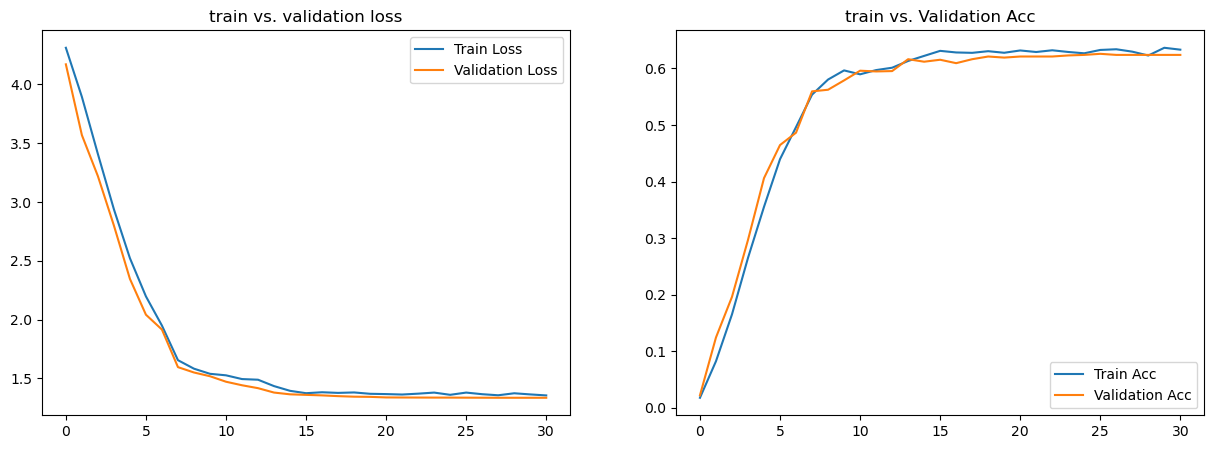

In [74]:
plt.figure(figsize = (15 , 5))

plt.subplot(1,2,1)
plt.plot(logs['train_loss'] , label = 'Train Loss')
plt.plot(logs['val_loss'] , label = 'Validation Loss')
plt.title('train vs. validation loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(logs['train_acc'] , label = 'Train Acc')
plt.plot(logs['val_acc'] , label = 'Validation Acc')
plt.title('train vs. Validation Acc')
plt.legend()



In [75]:
# Perfect Curves I wish I see every time I train a model ♥

##### confusion metrics

In [76]:
# cm ``
y_true , y_pred = [] , []
custom_model_1.eval()
with torch.inference_mode():
    for batch , (x , y) in enumerate(val_dataloader):
        x , y = x.to(device) , y.to(device)
        preds = custom_model_1(x)
        pred_classes = torch.argmax(torch.softmax(preds , dim = 1) , dim = 1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(pred_classes.cpu().numpy())
y_true , y_pred = np.array(y_pred),np.array(y_pred)
cm = confusion_matrix(y_true , y_pred)

In [77]:
cm

array([[12,  0,  0, ...,  0,  0,  0],
       [ 0, 22,  0, ...,  0,  0,  0],
       [ 0,  0, 19, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 21,  0,  0],
       [ 0,  0,  0, ...,  0, 16,  0],
       [ 0,  0,  0, ...,  0,  0,  7]], dtype=int64)

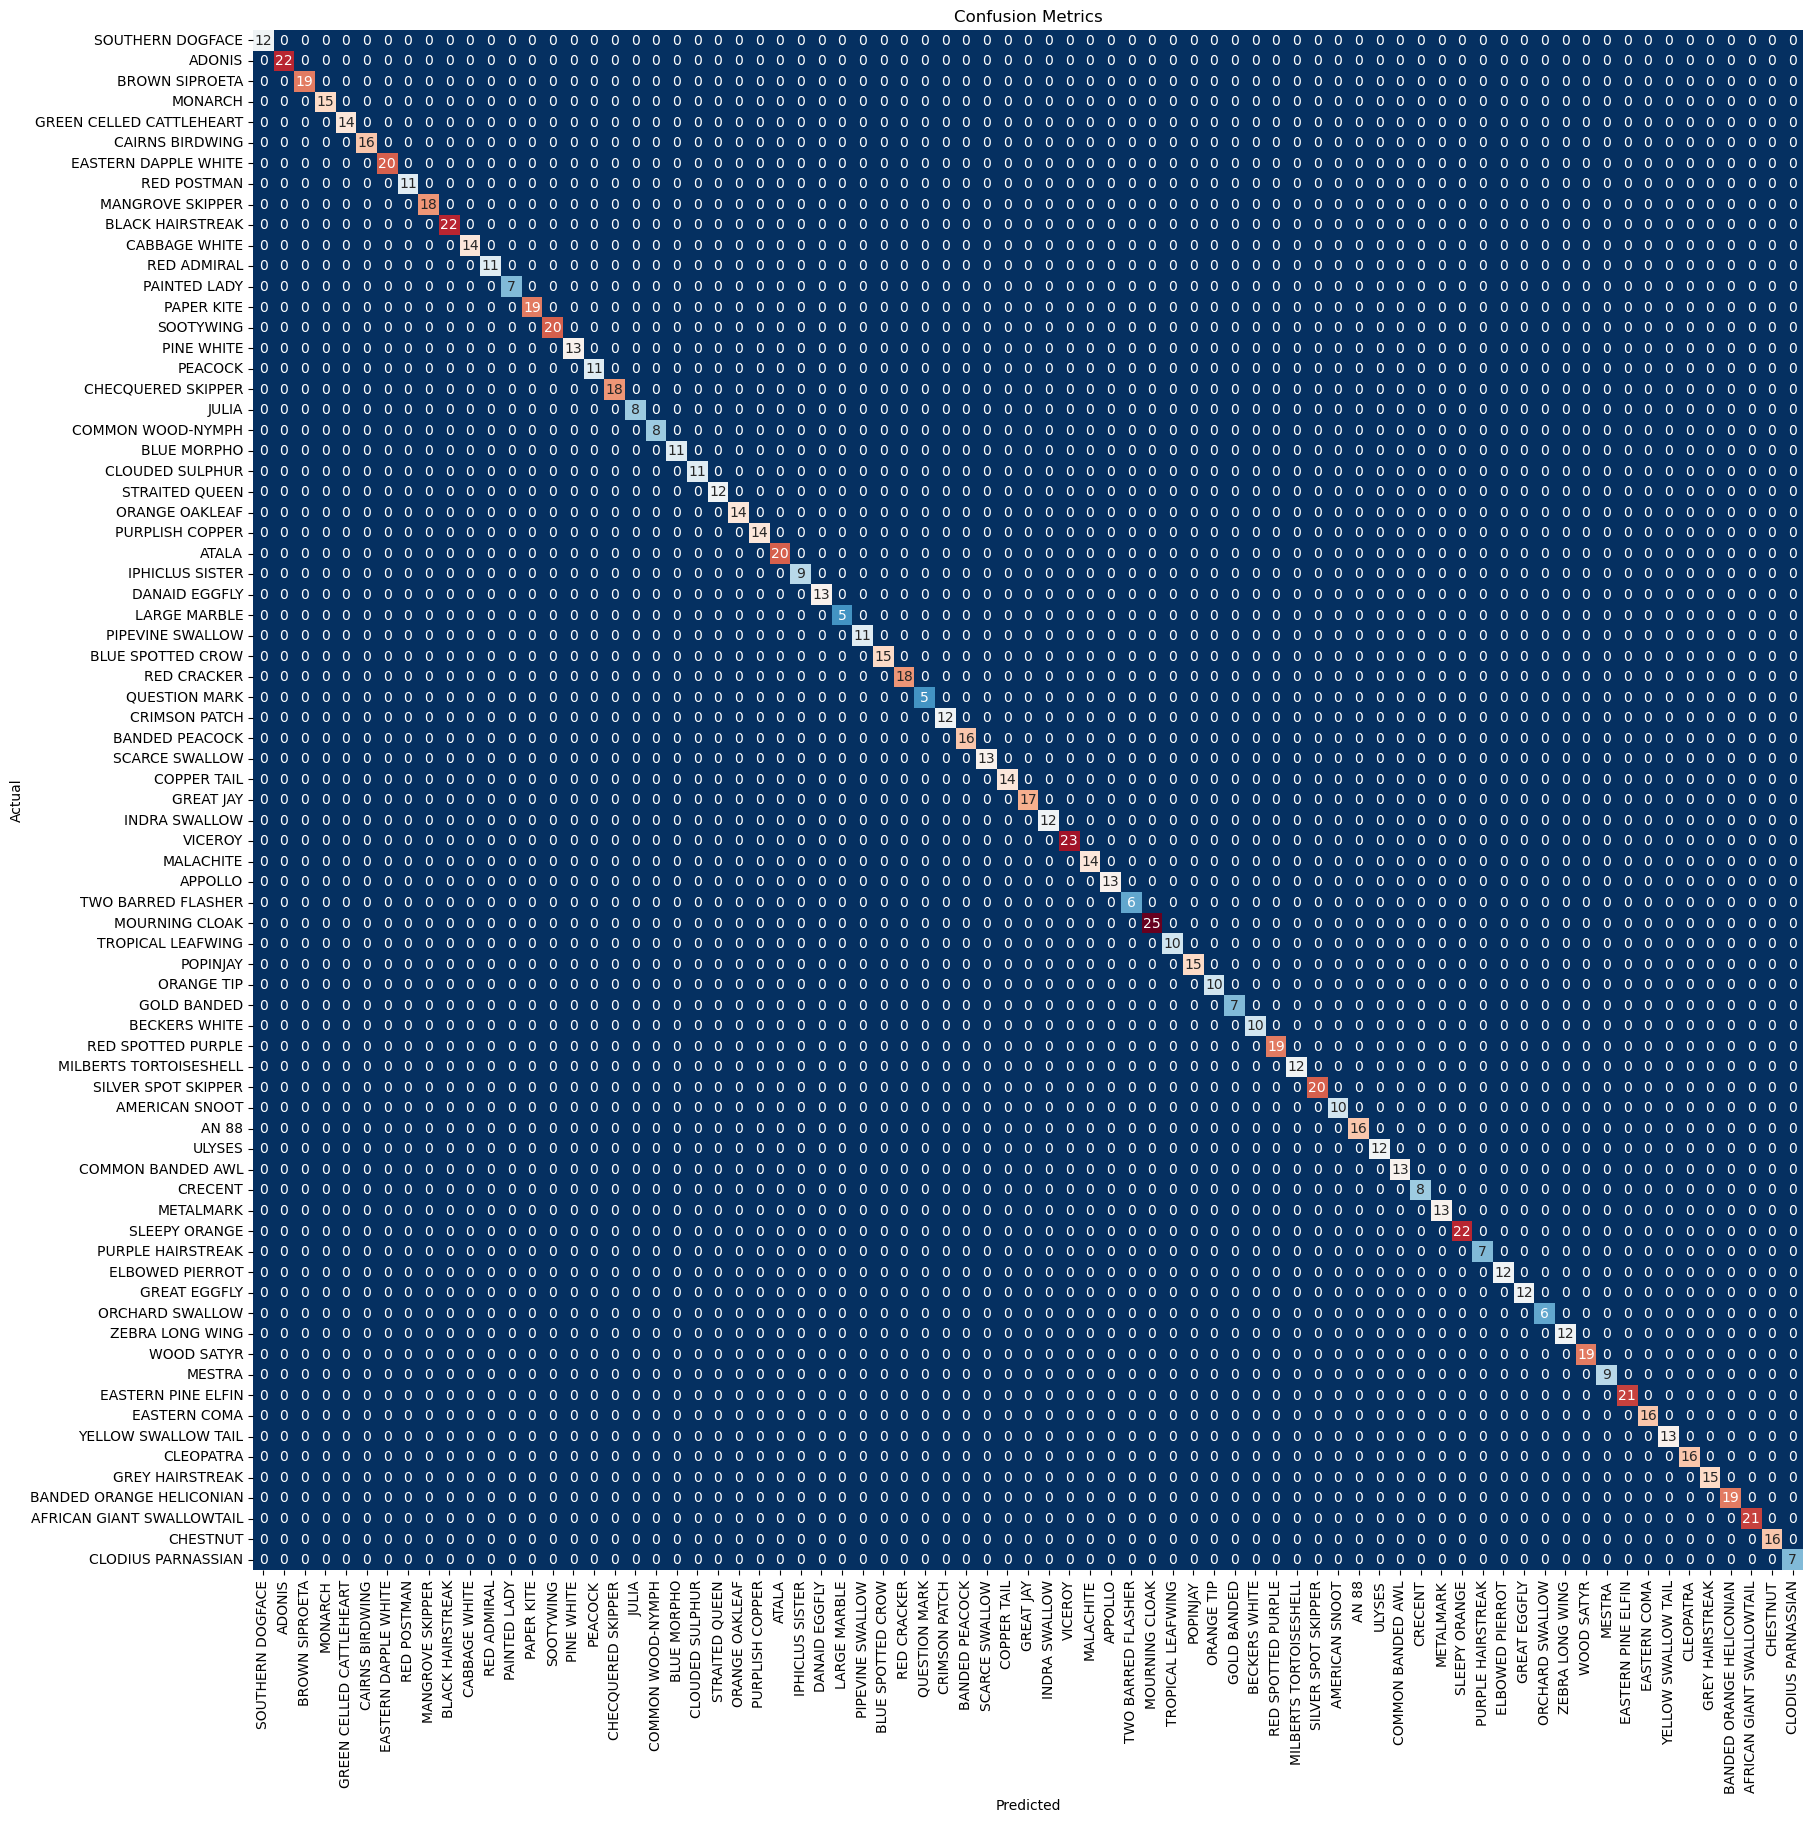

In [78]:
plt.rcParams["figure.figsize"] = (20,20)
ax = plt.subplot() 
sns.heatmap(cm , annot = True , fmt= 'g' , ax = ax , cbar = False , cmap = 'RdBu_r' , 
           xticklabels = class_names ,  yticklabels = class_names )
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Metrics')
plt.show()

##### classification_report

In [79]:
clf_report = classification_report(y_true , y_pred , target_names = class_names , output_dict = True)
clf_df = pd.DataFrame(clf_report)
clf_df

,SOUTHERN DOGFACE,ADONIS,BROWN SIPROETA,MONARCH,GREEN CELLED CATTLEHEART,CAIRNS BIRDWING,EASTERN DAPPLE WHITE,RED POSTMAN,MANGROVE SKIPPER,BLACK HAIRSTREAK,...,YELLOW SWALLOW TAIL,CLEOPATRA,GREY HAIRSTREAK,BANDED ORANGE HELICONIAN,AFRICAN GIANT SWALLOWTAIL,CHESTNUT,CLODIUS PARNASSIAN,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
support,12.0,22.0,19.0,15.0,14.0,16.0,20.0,11.0,18.0,22.0,...,13.0,16.0,15.0,19.0,21.0,16.0,7.0,1.0,1039.0,1039.0


In [80]:
clf_df.transpose()

,precision,recall,f1-score,support
SOUTHERN DOGFACE,1.0,1.0,1.0,12.0
ADONIS,1.0,1.0,1.0,22.0
BROWN SIPROETA,1.0,1.0,1.0,19.0
MONARCH,1.0,1.0,1.0,15.0
GREEN CELLED CATTLEHEART,1.0,1.0,1.0,14.0
...,...,...,...,...
CHESTNUT,1.0,1.0,1.0,16.0
CLODIUS PARNASSIAN,1.0,1.0,1.0,7.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,1039.0


# TransferLearning - PreTranied Models
#### in this seciton we will try to use transfer learning or pre_trained model to see if we can impove our model accuracy

In [81]:
# using pre-trained and famous   resnet
resnet18_model = pretrained_models.resnet18(weights='DEFAULT' )




In [82]:
resnet18_model.fc = nn.Linear(in_features=resnet18_model.fc.in_features,
                               out_features=len(class_names))

In [83]:
resnet18_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Traning Parameters  - Resnet 18 

In [86]:

BATCH_SIZE_resnet = 42

epochs_resnet = 300

device = torch.device("cpu")
logs_resnet = {'train_acc':[] , 'train_loss':[],
       'val_acc':[] , 'val_loss':[]}

lr_rate_resnet = 0.001
lr_milstones_resnet = [7 , 14 , 21 , 28 , 35]
optimizer_resnet = torch.optim.Adam(resnet18_model.parameters() , lr=lr_rate_resnet )

multi_step_lr_scheduler_resnet = lr_scheduler.MultiStepLR(optimizer_resnet ,
                                                   milestones=lr_milstones_resnet,
                                                  gamma = 0.1)



criterion_resnet = nn.CrossEntropyLoss()
patience = 8 
counter = 0
best_loss = 100_000_000 #very big numper you can use np.inf but I prefer this

In [87]:
for epoch in tqdm(range(epochs_resnet)):
    train_acc , train_loss = train_one_epoch(train_dataloader ,
                                            resnet18_model,
                                            criterion_resnet,
                                            optimizer_resnet,
                                            multi_step_lr_scheduler_resnet)
    val_acc , val_loss = validate(val_dataloader , resnet18_model , criterion_resnet)
    
    logs_resnet['train_acc'].append(train_acc.cpu())
    logs_resnet['train_loss'].append(train_loss)
    logs_resnet['val_acc'].append(val_acc.cpu())
    logs_resnet['val_loss'].append(val_loss)
    
    print(f"epoch:{epoch}")
    print(f"train_acc: {train_acc:.4f} , train_loss: {train_loss:.4f} / val_acc:{val_acc:.4f} , val_loss:{val_loss:.4f}")
    
    if best_loss - val_loss > 0.01:
        counter = 0
        best_loss = val_loss
        if Path('check_points_resnet').is_dir() == False: os.mkdir('check_points_resnet')
        torch.save(resnet18_model.state_dict() , f'check_points_resnet\\custom_model_1_epoch_{epoch}_acc_{int(val_acc*100)}.pth')
    else:
        counter += 1
        if counter >= patience:
            print('Early stop !!!')
            break

  0%|▎                                                                             | 1/300 [05:17<26:22:21, 317.53s/it]

epoch:0
train_acc: 0.5965 , train_loss: 1.5624 / val_acc:0.7242 , val_loss:0.9231


  1%|▌                                                                             | 2/300 [10:52<27:06:59, 327.58s/it]

epoch:1
train_acc: 0.7927 , train_loss: 0.7025 / val_acc:0.7175 , val_loss:0.9879


  1%|▊                                                                             | 3/300 [16:29<27:22:49, 331.88s/it]

epoch:2
train_acc: 0.8463 , train_loss: 0.5288 / val_acc:0.7732 , val_loss:0.7540


  1%|█                                                                             | 4/300 [21:56<27:08:32, 330.11s/it]

epoch:3
train_acc: 0.8643 , train_loss: 0.4431 / val_acc:0.8231 , val_loss:0.5027


  2%|█▎                                                                            | 5/300 [27:32<27:13:12, 332.18s/it]

epoch:4
train_acc: 0.8818 , train_loss: 0.3859 / val_acc:0.8844 , val_loss:0.3728


  2%|█▌                                                                            | 6/300 [33:15<27:26:05, 335.94s/it]

epoch:5
train_acc: 0.8959 , train_loss: 0.3367 / val_acc:0.9225 , val_loss:0.2532


  2%|█▊                                                                            | 7/300 [38:50<27:19:06, 335.65s/it]

epoch:6
train_acc: 0.9148 , train_loss: 0.2671 / val_acc:0.9088 , val_loss:0.2864


  3%|██                                                                            | 8/300 [44:34<27:26:15, 338.27s/it]

epoch:7
train_acc: 0.9543 , train_loss: 0.1484 / val_acc:0.9819 , val_loss:0.0638


  3%|██▎                                                                           | 9/300 [50:12<27:19:54, 338.13s/it]

epoch:8
train_acc: 0.9733 , train_loss: 0.0964 / val_acc:0.9857 , val_loss:0.0467


  3%|██▌                                                                          | 10/300 [55:43<27:03:37, 335.92s/it]

epoch:9
train_acc: 0.9792 , train_loss: 0.0766 / val_acc:0.9886 , val_loss:0.0382


  4%|██▊                                                                        | 11/300 [1:01:19<26:58:51, 336.10s/it]

epoch:10
train_acc: 0.9806 , train_loss: 0.0687 / val_acc:0.9886 , val_loss:0.0346


  4%|███                                                                        | 12/300 [1:06:49<26:43:33, 334.08s/it]

epoch:11
train_acc: 0.9827 , train_loss: 0.0613 / val_acc:0.9914 , val_loss:0.0286


  4%|███▎                                                                       | 13/300 [1:12:24<26:39:51, 334.46s/it]

epoch:12
train_acc: 0.9862 , train_loss: 0.0531 / val_acc:0.9914 , val_loss:0.0242


  5%|███▌                                                                       | 14/300 [1:18:05<26:43:22, 336.37s/it]

epoch:13
train_acc: 0.9862 , train_loss: 0.0453 / val_acc:0.9943 , val_loss:0.0219


  5%|███▊                                                                       | 15/300 [1:23:55<26:57:18, 340.48s/it]

epoch:14
train_acc: 0.9919 , train_loss: 0.0393 / val_acc:0.9924 , val_loss:0.0221


  5%|████                                                                       | 16/300 [1:29:22<26:32:48, 336.51s/it]

epoch:15
train_acc: 0.9902 , train_loss: 0.0395 / val_acc:0.9933 , val_loss:0.0198


  5%|████                                                                       | 16/300 [1:29:55<26:36:09, 337.22s/it]


KeyboardInterrupt: 

### Evaluating Model

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(logs_resnet['train_loss'] , label = 'Train Loss')
plt.plot(logs_resnet['val_loss'] , label = 'Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(logs_resnet['train_acc'] , label = 'Train Acc')
plt.plot(logs_resnet['val_acc'] , label = 'Validation Acc')
plt.legend()

### confusion metrics of  resnet model 

In [ ]:
y_true , y_pred = [] , []
resnet18_model.eval()
with torch.inference_mode():
    for batch , (x , y) in enumerate(val_dataloader):
        x , y = x.to(device) , y.to(device)
        preds = resnet18_model(x)
        pred_classes = torch.argmax(torch.softmax(preds , dim = 1), dim = 1)
        y_pred.extend(pred_classes.cpu().numpy())
        y_true.extend(y.cpu().numpy())
        
        
y_pred , y_true = np.array(y_pred) ,np.array( y_true)
cm_resnet18 = confusion_matrix(y_true , y_pred)    

In [ ]:
plt.figure(figsize = (20 , 20))
ax = plt.subplot()
sns.heatmap(cm_resnet18 , annot = True, fmt = 'g' ,xticklabels= class_names , yticklabels = class_names)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Metrics')
plt.show()


In [ ]:
#our model is LITTLE confused in the floowing two kinds lets check them: GREAT EGGFLY ,DANAID EGGFLY

In [ ]:
train_df[(train_df['label'] == 'GREAT EGGFLY' ) ^ (train_df['label'] == 'DANAID EGGFLY' ) ]

In [ ]:
# classification_report
clf_report_resnet18 = classification_report(y_true , y_pred ,output_dict=True)
pd.DataFrame(clf_report_resnet18)

In [ ]:
pd.DataFrame(clf_report_resnet18).transpose()

### using pre-trained model : swin_v2_b


In [ ]:
swin_model = pretrained_models.swin_v2_b(weights='DEFAULT') 

In [ ]:
swin_model.head = nn.Linear(swin_model.head.in_features , out_features=len(class_names))
swin_model.to(device)

In [ ]:
swin_model(torch.randn(1,3,224,224).to(device))

In [ ]:
device

### Traning Parameters

In [ ]:
epochs_swin = 300
best_loss = 100_100_000
patience = 8
counter = 0

logs_swin = {'train_acc':[] , 'train_loss':[] , 'val_acc':[] , 'val_loss':[]}

criterion_swin = nn.CrossEntropyLoss()
momentum = 0.9
lr_rate_swin = 0.01

lr_rate_milstones_swin = [7 , 14 , 21 , 28 , 35 , 42 , 49]
optimizer_swin = torch.optim.Adam(swin_model.parameters() , lr = lr_rate_swin )
lr_multisetp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer_swin , milestones= lr_rate_milstones_swin,
                                                    gamma = .1)


In [ ]:
for epoch in tqdm(range(epochs_swin)):
    train_acc , train_loss = train_one_epoch(train_dataloader , swin_model , criterion_swin ,
                                             optimizer_swin , lr_multisetp_lr_scheduler)
    val_acc , val_loss = validate(val_dataloader, swin_model ,
                                 criterion_swin)
    logs_swin['train_acc'].append( train_acc)
    logs_swin['train_loss'].append(train_loss)
    logs_swin['val_acc'].append(val_acc)
    logs_swin['val_loss'].append(val_loss)
    
    print(f"epoch:{epoch}")
    print(f"train_acc: {train_acc:.4f} , train_loss: {train_loss:.4f} / val_acc:{val_acc:.4f} , val_loss:{val_loss:.4f}")
    
    
    if best_loss - val_loss > 0.01:
        best_loss = val_loss
        val_acc_wr = int(100 * val_loss)
        if Path('check_points_swin_v2_b').is_dir() == False:os.mkdir('check_points_swin_v2_b')
        torch.save(swin_model.state_dict() , f'check_points_swin_v2_b\\model_epoch_{epoch}_acc_{val_acc_wr}.pth')
    else:
        counter += 1
        if counter >= patience:
            print('Early stop !!!')
            break

#### Evaluating Model

In [ ]:
logs_swin['val_acc'] = [val_tm.cpu().item() for val_tm in logs_swin['val_acc']]

In [ ]:
plt.subplots()

plt.subplot(1,2,1)
plt.plot(logs_swin['train_acc'] , label = 'Train Accuaracy')
plt.plot(logs_swin['val_acc'] , label = 'Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(logs_swin['train_loss'] , label = 'Train Loss')
plt.plot(logs_swin['val_loss'] , label = 'Validation Loss')
plt.legend()




#### Confusion metrics 

In [ ]:
y_true , y_predicted = [] , []

swin_model.eval()
with torch.inference_mode():
    for batch , (x, y )in tqdm(enumerate(val_dataloader)):
        x , y = x.to(device) , y.to(device)
        preds = swin_model(x)
        pred_classes = torch.argmax(torch.softmax(preds , dim = 1) , dim = 1)
        y_predicted.extend(pred_classes.cpu().numpy())
        y_true.extend(pred_classes.cpu().numpy())
y_predicted , y_true = np.array(y_predicted) , np.array(y_true)
cm_swin = confusion_matrix(y_true , y_predicted)

In [ ]:
plt.figure(figsize = (20,20))
ax=plt.subplot()
sns.heatmap(cm_swin , annot = True , xticklabels = class_names , yticklabels = class_names , fmt = 'g')
ax.set_xlabel('predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()


#### classification_report

In [ ]:
clf_report_swin = classification_report(y_true , y_predicted , output_dict = True)
pd.DataFrame(clf_report_swin)

In [ ]:
pd.DataFrame(clf_report_swin).transpose()

In [ ]:
# aparently you can use now the resnet 18 model to predict the test images. 
#I will leave this to you 

Hope you have enjoyed this Notebook :)